# Practical work 8: Split and Merge

In this practical work, we implement and test the split and merge algorithm.

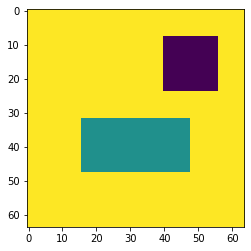

In [1]:
### Usefull libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic

### Data
img_test = np.full((64,64),150,dtype=np.uint8)
img_test[32:48,16:16+32] = 100
img_test[8:24,40:56] = 50
angio = np.array(Image.open('img/angiogra.png'))
cam = np.array(Image.open('img/cameraman.png'))
muscle = np.array(Image.open('img/muscle.png'))
prisme = np.array(Image.open('img/prisme.png'))
seiche = np.array(Image.open('img/seiche.png'))

### Usefull functions
def neighbors(b,K):
    """ blockStat*list[blockStat]->list[blockStat]
        returns the list of neighbors of b and elements of K 
    """
    def belongsTo(x,y,a):
        """ int*int*BlockStat -> bool 
            Test if pixel (x,y) belongs to block a 
        """
        return x>=a[0] and y>=a[1] and x<a[0]+a[2] and y<a[1]+a[3]
    def areNeighbors(a,b):
        """ BlockStat**2 -> bool
            Test if a and b are neighbors
        """
        if a[2]>b[2] and a[3]>b[3]:
            a,b=b,a
        x,y = a[0]+a[2]//2,a[1]+a[3]//2
        return belongsTo(x+a[2],y,b) or belongsTo(x-a[2],y,b) or belongsTo(x,y+a[3],b) or belongsTo(x,y-a[3],b)
    N = []
    for n in K:
        if areNeighbors(b,n):
            N.append(n)
    return N
plt.imshow(img_test)

## Exercise 1

### Question 1
Write the recursive function ``split()`` discussed in tutorial work. 
It takes as input the image, a region, a predicate, and a variable number of arguments. 
The region is a Python formal type ``Block`` defined by:
```python
type Block = tuple[int**4]
```
The function ``split()`` returns a quadtree, a Python formal type, recursivelly defined by:
```python
type QuadTree = list[(QuadTree**4|Block)] 
```

The predicate is a Python function with the following signature:
```python
Array*Block*...->bool
```
It can take a variable number of parameters which correspond to the parameters required by the predicate.

In [2]:
# type Block = tuple[int**4]
# type QuadTree = list[(QuadTree**4|Block)] 

def split(I,reg,pred,*args):
    """ Array*Block*(Array*Block*...->bool)*... -> 4-aire
        Performs a quadtree splitting of image I drived by a predicate
    """
    if pred(I, reg, *args):
        x = reg[0]
        y = reg[1]
        splited_n = reg[2]//2
        splited_m = reg[3]//2
        new_size = (splited_n, splited_m)
        return [
            split(I, (x             , y              , *new_size), pred, *args), # Nord Ouest
            split(I, (x             , y + splited_m  , *new_size), pred, *args), # Nord Est
            split(I, (x + splited_n , y              , *new_size), pred, *args), # Sud Ouest
            split(I, (x + splited_n , y + splited_m  , *new_size), pred, *args), # Sud Est
        ]
    else:
        return reg

### Question 2
Write the function ```predsplit(I,B,*args)``` with signature:
```python
Array*Block*... -> bool
```
that returns True if the standard deviation of image ``I`` computed in region ``B`` is greater than the first value of argument ``*args`` (it can be accessed simply by ``*args[0]``).

In [3]:
def predsplit(I,reg,*args):
    """ Array*Block*... -> bool
    """
    x,y,n,m = reg
    if np.std(I[x:x+n, y:y+m]) > args[0] :
        return True 
    else:
        return False

### Question 3
Write the function ``listRegions()`` which applies a depth-first search on the quadtree given as parameter, and returns the list of the leaves of the quadtree. 

Some recalls about lists in Python;
 - Initialization: `L = []` (empty list)
 - Add a element `a` into a list `L`: `L.append(a)`

In [4]:
def listRegions(L, blocks_list):
    """ QuadTree -> list[Block]
    """
    if isinstance(L, tuple): # C'est une feuille 
        blocks_list.append(L)
        return blocks_list
    else:
        for qt in L:
            listRegions(qt, blocks_list)
        return blocks_list

### Question 4
Test your codes on the synthetic image ``img_test`` seen in tutorial work. Print the value returned by ``split()`` as well as the one returned by ``listRegions()``. 

In [5]:
L = split(img_test, (0,0, *img_test.shape), predsplit, 0)
L

[(0, 0, 32, 32),
 [[(0, 32, 8, 8), (0, 40, 8, 8), (8, 32, 8, 8), (8, 40, 8, 8)],
  [(0, 48, 8, 8), (0, 56, 8, 8), (8, 48, 8, 8), (8, 56, 8, 8)],
  [(16, 32, 8, 8), (16, 40, 8, 8), (24, 32, 8, 8), (24, 40, 8, 8)],
  [(16, 48, 8, 8), (16, 56, 8, 8), (24, 48, 8, 8), (24, 56, 8, 8)]],
 [(32, 0, 16, 16), (32, 16, 16, 16), (48, 0, 16, 16), (48, 16, 16, 16)],
 [(32, 32, 16, 16), (32, 48, 16, 16), (48, 32, 16, 16), (48, 48, 16, 16)]]

In [6]:
regions = listRegions(L, [])
print(regions)
len(regions)

[(0, 0, 32, 32), (0, 32, 8, 8), (0, 40, 8, 8), (8, 32, 8, 8), (8, 40, 8, 8), (0, 48, 8, 8), (0, 56, 8, 8), (8, 48, 8, 8), (8, 56, 8, 8), (16, 32, 8, 8), (16, 40, 8, 8), (24, 32, 8, 8), (24, 40, 8, 8), (16, 48, 8, 8), (16, 56, 8, 8), (24, 48, 8, 8), (24, 56, 8, 8), (32, 0, 16, 16), (32, 16, 16, 16), (48, 0, 16, 16), (48, 16, 16, 16), (32, 32, 16, 16), (32, 48, 16, 16), (48, 32, 16, 16), (48, 48, 16, 16)]


25

### Question 5
Write the function ```drawRegions(L,I)``` which takes as arguments a list of regions, an image, and returns an image  where the boundaries of each region have been traced with red color. Indication: the returned image is a hypermatrix of dimension 3, the third dimension is of size 3 and encodes the red, green and blue components of a RGB colorspace. Test the function on the previous example.

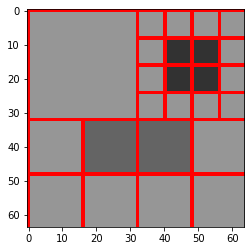

In [9]:
def drawRegions(LL,I):
    """ list[Block]*Array -> Array
        parcours de la liste dessin des régions 
    """
    new_I = np.dstack((I,I,I))
    red = np.array([255, 0, 0])
    for x, y, n, m in LL:
        for i in range(n): # Axe des x sur n pixel
            new_I[x+i, y, :] = red # On met le pixel en rouge
            # new_I[x+i, y+m-1, :] = red # On met le pixel en rouge
        
        for j in range(m): # Axe des j sur m pixel
            new_I[x, y+j, :] = red # On met le pixel en rouge
            # new_I[x+n, y+j-1, :] = red # On met le pixel en rouge
    return new_I

regions_img_test = drawRegions(regions, img_test)
plt.imshow(regions_img_test)

### Question 6
Add a Gaussian noise with standard deviation 5 to the image ``img_test``. 
Apply the quadtree splitting on the noisy image by adjusting the threshold to obtain the same result as in the previous question. 
Which threshold value should be chosen? Does this make sense to you?

Hint: use the Numpy function ``random.randn()`` which generates random values according to a normal distribution (Gaussian distribution of null mean and variance 1). To obtain realizations of a Gaussian distribution of standard deviation $\sigma$, it is sufficient to multiply by $\sigma$ the realizations of a normal distribution. 

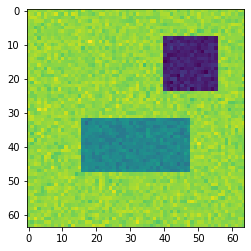

In [11]:
from numpy import random

def gaussian_noise(I, sig):
    noise = random.randn(*I.shape)*sig 
    return (I + noise).astype(int)

def show_segmentation(I, *args, ax=None):
    split_tree = split(I, (0,0, *I.shape), predsplit, *args)
    regions = listRegions(split_tree, [])
    regions_img = drawRegions(regions, I)
    if ax:
        ax.imshow(regions_img)
    else:
        plt.imshow(regions_img)
        plt.show()
    return regions_img

noisy_img_test = gaussian_noise(img_test, sig=5)
plt.imshow(noisy_img_test)

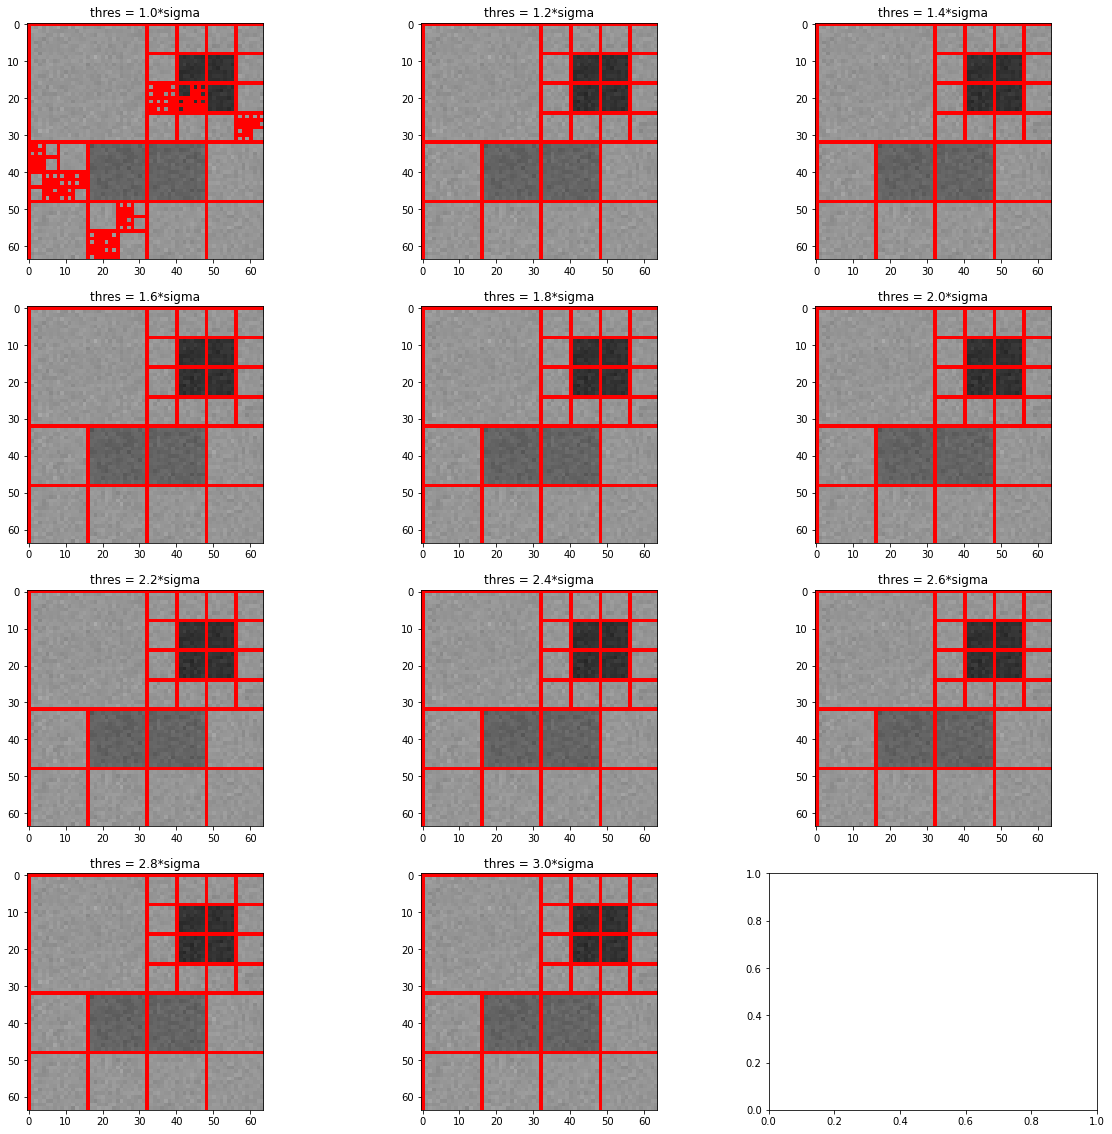

In [12]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20,20))
ax = ax.flatten()
n = 0
for i in np.arange(1, 3.2, 0.2):
    ax[n].set_title(f'thres = {round(i,2)}*sigma')
    show_segmentation(noisy_img_test, i*5, ax=ax[n])
    n += 1

**je sais pas ici**

## Exercise 2

Experiment the split algorithm on the 4 natural images provided. For each image try to find the threshold that seems to you visually the best. Display the number of regions obtained after splitting.

0

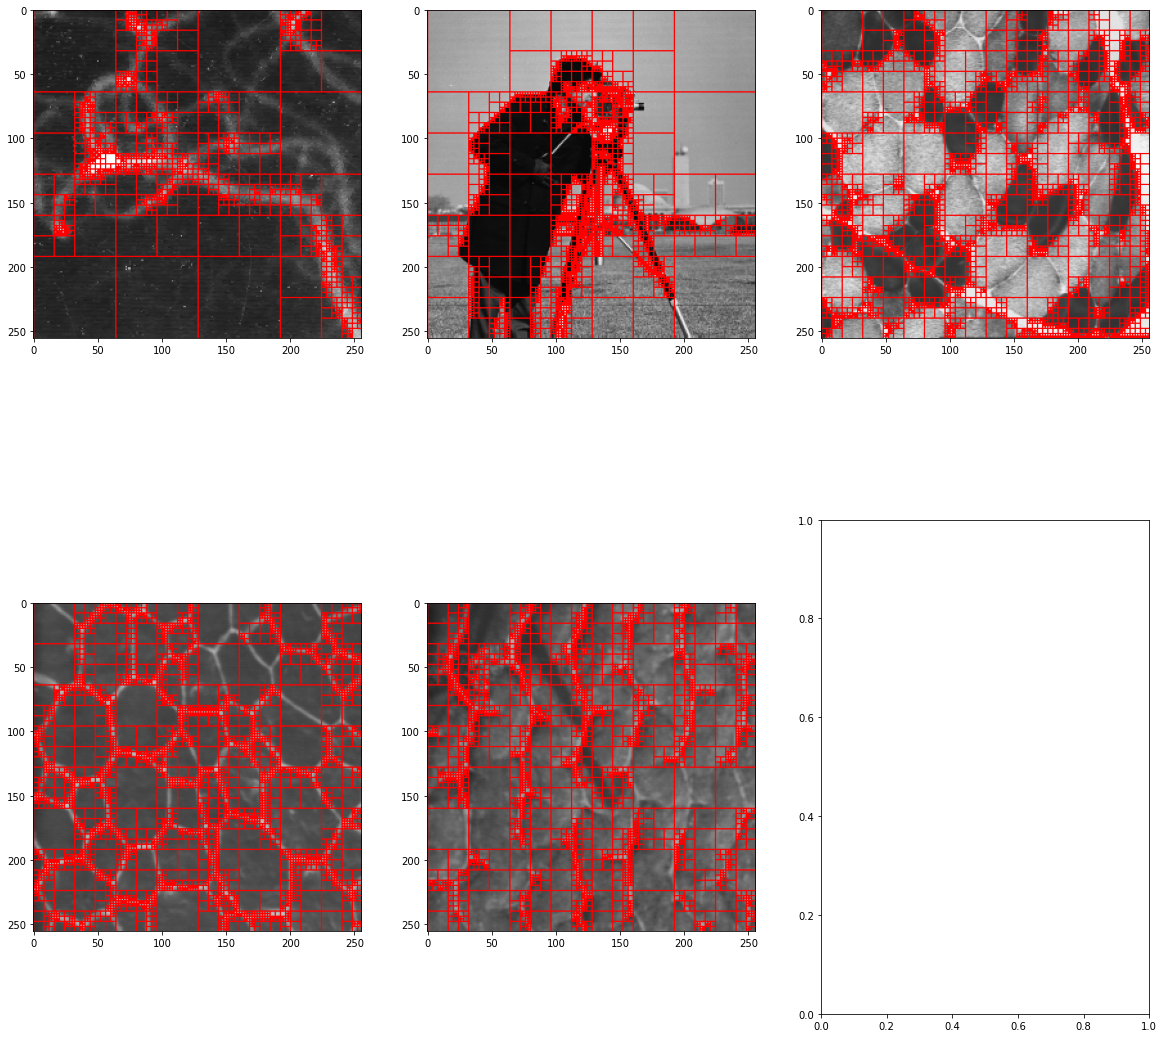

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,20))
ax = ax.flatten()
show_segmentation(angio, 20, ax=ax[0])
show_segmentation(cam, 30, ax=ax[1])
show_segmentation(muscle, 25, ax=ax[2])
show_segmentation(prisme, 19, ax=ax[3])
show_segmentation(seiche, 14, ax=ax[4])
0

## Exercise 3
### Question 1
Modify the function ``listRegions(L)`` to make it a function ``listRegionsStat(L,I)`` which computes the list of leaves of the quadtree ``L``. Each element of this list will be enriched with three scalar values: the first being the size, the second the mean and the third the variance of pixel values of the block in the image ``I``. This function then returns a list whose elements have the following formal type:
```python
type BlockStat = tuple[int**4,int,float**2]
```

The first four values are those of the ``Block`` type, the fifth is the size of the block (in number of pixels) and the last two values are the mean and variance calculated over the region.

In [39]:
# type BlockStat = tuple[int**4,int,float**2]
def compute_stats(reg, I):
    x,y,n,m = reg
    I_cut = I[x:x+n, y:y+m]
    return len(I_cut.flatten()), I_cut.mean(), I_cut.var()

def listRegionsStat(L,I, blocks_list):
    """ QuadTree*Array -> list[BlockStat] """
    if isinstance(L, tuple): # C'est une feuille 
        size, m, v = compute_stats(L, I)
        blocks_list.append((*L, size, m, v))
        return blocks_list
    else:
        for qt in L:
            listRegionsStat(qt, I, blocks_list)
        return blocks_list
listRegionsStat(L, img_test, [])[0]

(0, 0, 32, 32, 1024, 150.0, 0.0)

### Question 2
In the remainder, the formal type is considered:
```python
type Region = list[BlocStats]
```
A region, as seen during the tutorial work, is therefore a list of blocks. Write the predicate ``predmerge(b,R,*args)`` as seen in tutorial work. This function returns ``True`` if the ``b`` block should merge into the ``R`` region. If a merge happens, then the first item of ``R`` will have its statistics updated to describe the statistics of the region ``R`` merged with `b`.

In [ ]:
def predmerge(b,R,*args):
    """ BlocsStat*Region*... -> bool 
        If merge, R[0] is modified
    """
    for b in R

### Question 3
Using `predmerge()` and `neighbors()` functions, given at the beginning of the notebook, write the function ``merge()`` discussed in tutorial work (exercise 7.6).

Recalls on Python lists:
- Remove an element `a` from a list `L`: `L.remove(a)`
- Test if `a` belongs to a list `L`: `a in L` 
- Iterate the elements of a list `L`: `for a in L:`
- Access to an element of a list: as with numpy arrays

In [4]:
def merge(S,I,pred,*args):
    """ QuadTree*Array*(BlockStat*Region*...->bool) -> list[Region]
        Merge the leaves of S in a list of regions
    """
    K = listRegionsStat(S, I, [])
    L = []
    while len(K) != 0:
        b = K[0]
        reg = [b]
        K = K.pop(0)
        neighbors_list = neighbors(b, reg) # reg ou K ?
        for nb in neighbors_list:
            if pred(k, reg, *args):
                K.remove(nb)
                reg.append(nb)
                neighbors_list += neighbors(nb, reg)  # reg ou K ?
        L.append(reg)
    return L

### Question 4
Test the previous functions using the synthetic image `img_test`. In particular, check that merge() returns a list of 3 elements (i.e. 3 regions).

In [ ]:
def drawRegions2(LL,I):
    """ list[BlockStat]*Array -> Array
        parcours de la liste dessin des régions 
    """
    new_I = np.dstack((I,I,I))
    red = np.array([255, 0, 0])
    for x, y, n, m, _, _, _ in LL:
        for i in range(n): # Axe des x sur n pixel
            new_I[x+i, y, :] = red # On met le pixel en rouge
            # new_I[x+i, y+m-1, :] = red # On met le pixel en rouge
        
        for j in range(m): # Axe des j sur m pixel
            new_I[x, y+j, :] = red # On met le pixel en rouge
            # new_I[x+n, y+j-1, :] = red # On met le pixel en rouge
    return new_I

def show_segmentation_merge(I, predsplit, predmerge, args_split, args_merge, ax=None):
    """
    Image * predicat function split * predicat function merge * tuple[arg split] * tuple[arg merge] * ax facultatif
    """
    split_tree = split(I, (0,0, *I.shape), predsplit, *args_split)
    merged_region = merge(split_tree, predmerge, *args_merge)
    regions_img = drawRegions2(merged_region, I)
    if ax:
        ax.imshow(regions_img)
    else:
        plt.imshow(regions_img)
        plt.show()
    return regions_img

In [ ]:
QT = split(img_test, predsplit, ?)
M = merge(QT, predmerge, ?)
assert len(M) == 3

In [ ]:
show_segmentation_merge(img_test, predsplit, predmerge, (), ())

### Question 5
Write a function ``regions(LR,shape)`` that takes as arguments a list of regions (such as returned by the function ``merge()``) and an image size, and returns an image of the regions. Each region will be colored with the gray level corresponding to the average of the region. The ``shape`` parameter gives the size of the image to be produced. 

Test the function on the previous example.

In [ ]:
def regions(LR,shape):
    """ list[Region]*tuple[int,int] -> Array """
    

## Exercise 4: experiments
### Question 1
Test the function ``merge()`` on the images ``angio``, ``cam``, ``muscle``, ``prisme`` and ``seiche``. Try to produce the best segmentations.

### Question 2
The result of the merge algorithm highly depends on how you visit the regions. One can then sort the leaves of the quadtree, for example, from the smallest to the largest blocks, or the opposite (use the Python function ``sorted()``). 
The same question arises when calculating the set of neighbors of the merged region. Should they be sorted? If yes, according to which criteria? their size? their proximity? 
Obviously there is no universal answer but it should be adapted to each type of problem. 
Do some tests to see the influence of these sortings on the result of the merger.

### Question 3 (bonus)
Imagine and experiment alternative predicates for both the split and the merge steps. It is possible to use edges-based predicates, and also to combine with variance-based predicates.


**Faire des test sur plusieurs image, sur plusieurs prédicat, le merge a des variantes.**

**Il veut pas nous noter sur les algos qu'on a fait en TD.**